# Testing access times to cloud optimized HDF5 files with the fsspec and ROS3 drivers.

This notebook tests both I/O drivers on cloud optimized HDF5 files from the ICESat-2 mission. 

> Note: The ROS3 driver is only available in the Conda distribution of h5py

In [1]:
import fsspec
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from dask.distributed import Client, LocalCluster
import dask.bag as db
from dask.diagnostics import ProgressBar

from h5logger import parse_fsspec_log, read_file


for library in (h5py, fsspec):
    print(f'{library.__name__} v{library.__version__}')

h5py v3.11.0
fsspec v2024.9.0


The folowing dictionary is generic enough that we can use it for different datasets, we only require file URLS and the variables we want to read from them using h5py. 
The tests take for granted that the original file has no cloud optimizations and can not be read using cloud optimized patterns, the next check is to verify if the keywords "paged" or "rechunked" are present in the file name, it's presumed to be cloud optimized. 

This notebook uses dask to speed up the testing, we issue requests to each file at the same time, first looping using default parameters, this is to learn what happens when we access the different flavors without knowing that some are cloud optimized. Then we use optimized I/O parameters, we do the same for both fsspec and the HDF5 native driver ROS3. 

In [2]:
test_dict = {
    "ATL03-7GB": {
        "files": {
            "original": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02.h5",
            "page-only-4mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-page-only-4mb.h5",
            "page-only-8mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02-page-only-8mb.h5",
            "rechunked-4mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02_rechunked-100k-page-4mb.h5",
            "rechunked-8mb": "s3://its-live-data/test-space/cloud-experiments/h5cloud/atl03/ATL03_20181120182818_08110112_006_02_rechunked-100k-page-8mb.h5",
        },
        "variables": ["/gt1l/heights/h_ph", "/gt1l/heights/lat_ph", "/gt1l/heights/lon_ph"]
    },
}

In [ ]:
# If there is a dask_client cluster let's not create new ones.
if "dask_client" not in locals():
    cluster = LocalCluster(threads_per_worker=1)
    dask_client = Client(cluster)
    dask_client

The importance of caching and over-reads with remote files

* **simple**: Caches entire files on disk.
* **blockcache**: Caches file data in chunks (blocks) on memory.
* **bytes**: Caches entire files in memory.
* **none**: Does not use caching on any request

In [4]:
num_runs = 1
benchmarks = []
ranges = []

#the real default is readahead with 5MB of block sizes, we disabled to test real times without caching anything
default_io_params = {
    "fsspec_params": {
        "skip_instance_cache": True,
        "cache_type": "none"
        # "cache_type": "first", # could be first, or cachiing the entier file with simple, 
        # "block_size": 4*1024*1024
    },
    "h5py_params": {}
}

# we can fine-tune these
optimized_io_params ={
    "fsspec_params": {
        "cache_type": "blockcache", # could be first, or cachiing the entier file with simple, 
        "block_size": 8*1024*1024
    },
    "h5py_params" : {
        "page_buf_size": 16*1024*1024,
        "rdcc_nbytes": 4*1024*1024
    }
}

for optimized_read in [False, True]:
    for driver in ["ros3", "fsspec"]:
        for run in range(num_runs):  # Running N times
            for dataset_name, dataset_item in test_dict.items():
                # Inner loop (parallelized)
                urls = dataset_item["files"].items()            
                benchmark_list = [(run, dataset_name, dataset_item["variables"], flavor, url, optimized_read, driver, default_io_params, optimized_io_params) for flavor, url in urls]
                bag = db.from_sequence(benchmark_list, npartitions=len(benchmark_list))
                result = bag.map(read_file)
                with ProgressBar():
                    results = result.compute()
                    for result in results:
                        if len(result["benchmark"]):
                            benchmarks.append(result["benchmark"])
                        # For now we can only log I/O with fsspec
                        if result["benchmark"]["driver"] == "fsspec":
                            ranges.append(result["ranges"])
                        
df = pd.DataFrame.from_dict(benchmarks)

Now that we have collected the information we need we are going to plot how the drivers and the parameters performed.
The "baseline" is what HDF5 and fsspec do when they don't use cloud optimized parameters on a non-optimized file. Here is when we see the worst performance due te many small serial request to cloud storage. Presumably, the best case would be when we use optimized I/O that aligns to the scheme used for a cloud optimized file. E.G. if a file was optimized using paged aggregation and page sizes of 4MB, the best performance should be when we tell the I/O driver that we should read 4MB at the time. 

<Figure size 1000x600 with 0 Axes>

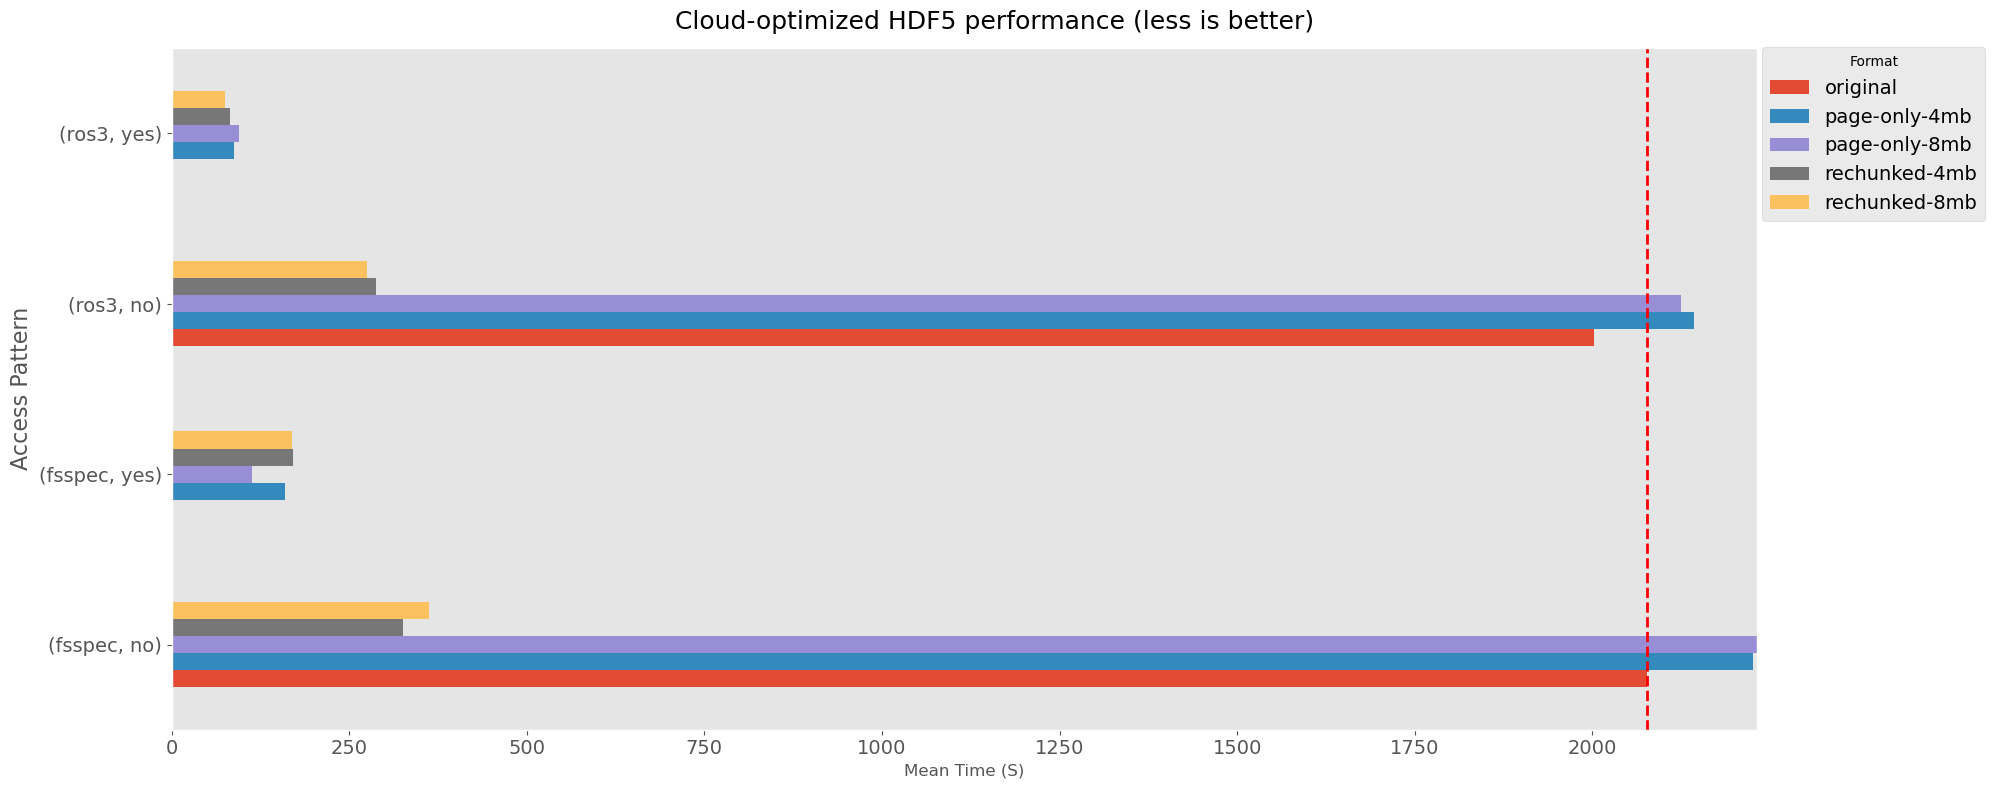

In [7]:
plt.figure(figsize=(10, 6)) 
plt.style.use('ggplot')

x_max = max(df["time"])
pivot_df = df.pivot_table(index=['driver', 'optimized-read'], columns=['format', ], values='time', aggfunc='mean')
baseline_original = pivot_df['original'].max()

# Plotting
pivot_df.plot(kind='barh', figsize=(20, 8), fontsize=14, width=0.5)

plt.xlim(0, x_max)

plt.suptitle('Cloud-optimized HDF5 performance (less is better)', fontsize=18)
# plt.title("Default I/O parameters (ATL03_20181120182818_08110112_006_02.h5: 7GB)", fontsize=14)
plt.xlabel('Mean Time (S)')
plt.ylabel('Access Pattern', fontsize=16)
plt.xticks(rotation=0)
plt.legend(title='Format', fontsize=14, loc='upper right', bbox_to_anchor=(1.15, 1.015))
plt.grid(False)

plt.axvline(x=baseline_original, color='red', linestyle='--', linewidth=2, label=f"Baseline: {baseline_original:.2f}")

plt.tight_layout()
plt.savefig("h5py-default.png", transparent=True, dpi=150)

plt.show()

In [21]:
df.to_csv("h5py-atl03-benchmarks.csv")

The following cell is experimental, it plots the access pattern signature and the reads on a remote HDF5 file, optimized or not, we can only record the info using fsspec for now as ROS3 logging requires to compile h5py from scratch using custom flags. 

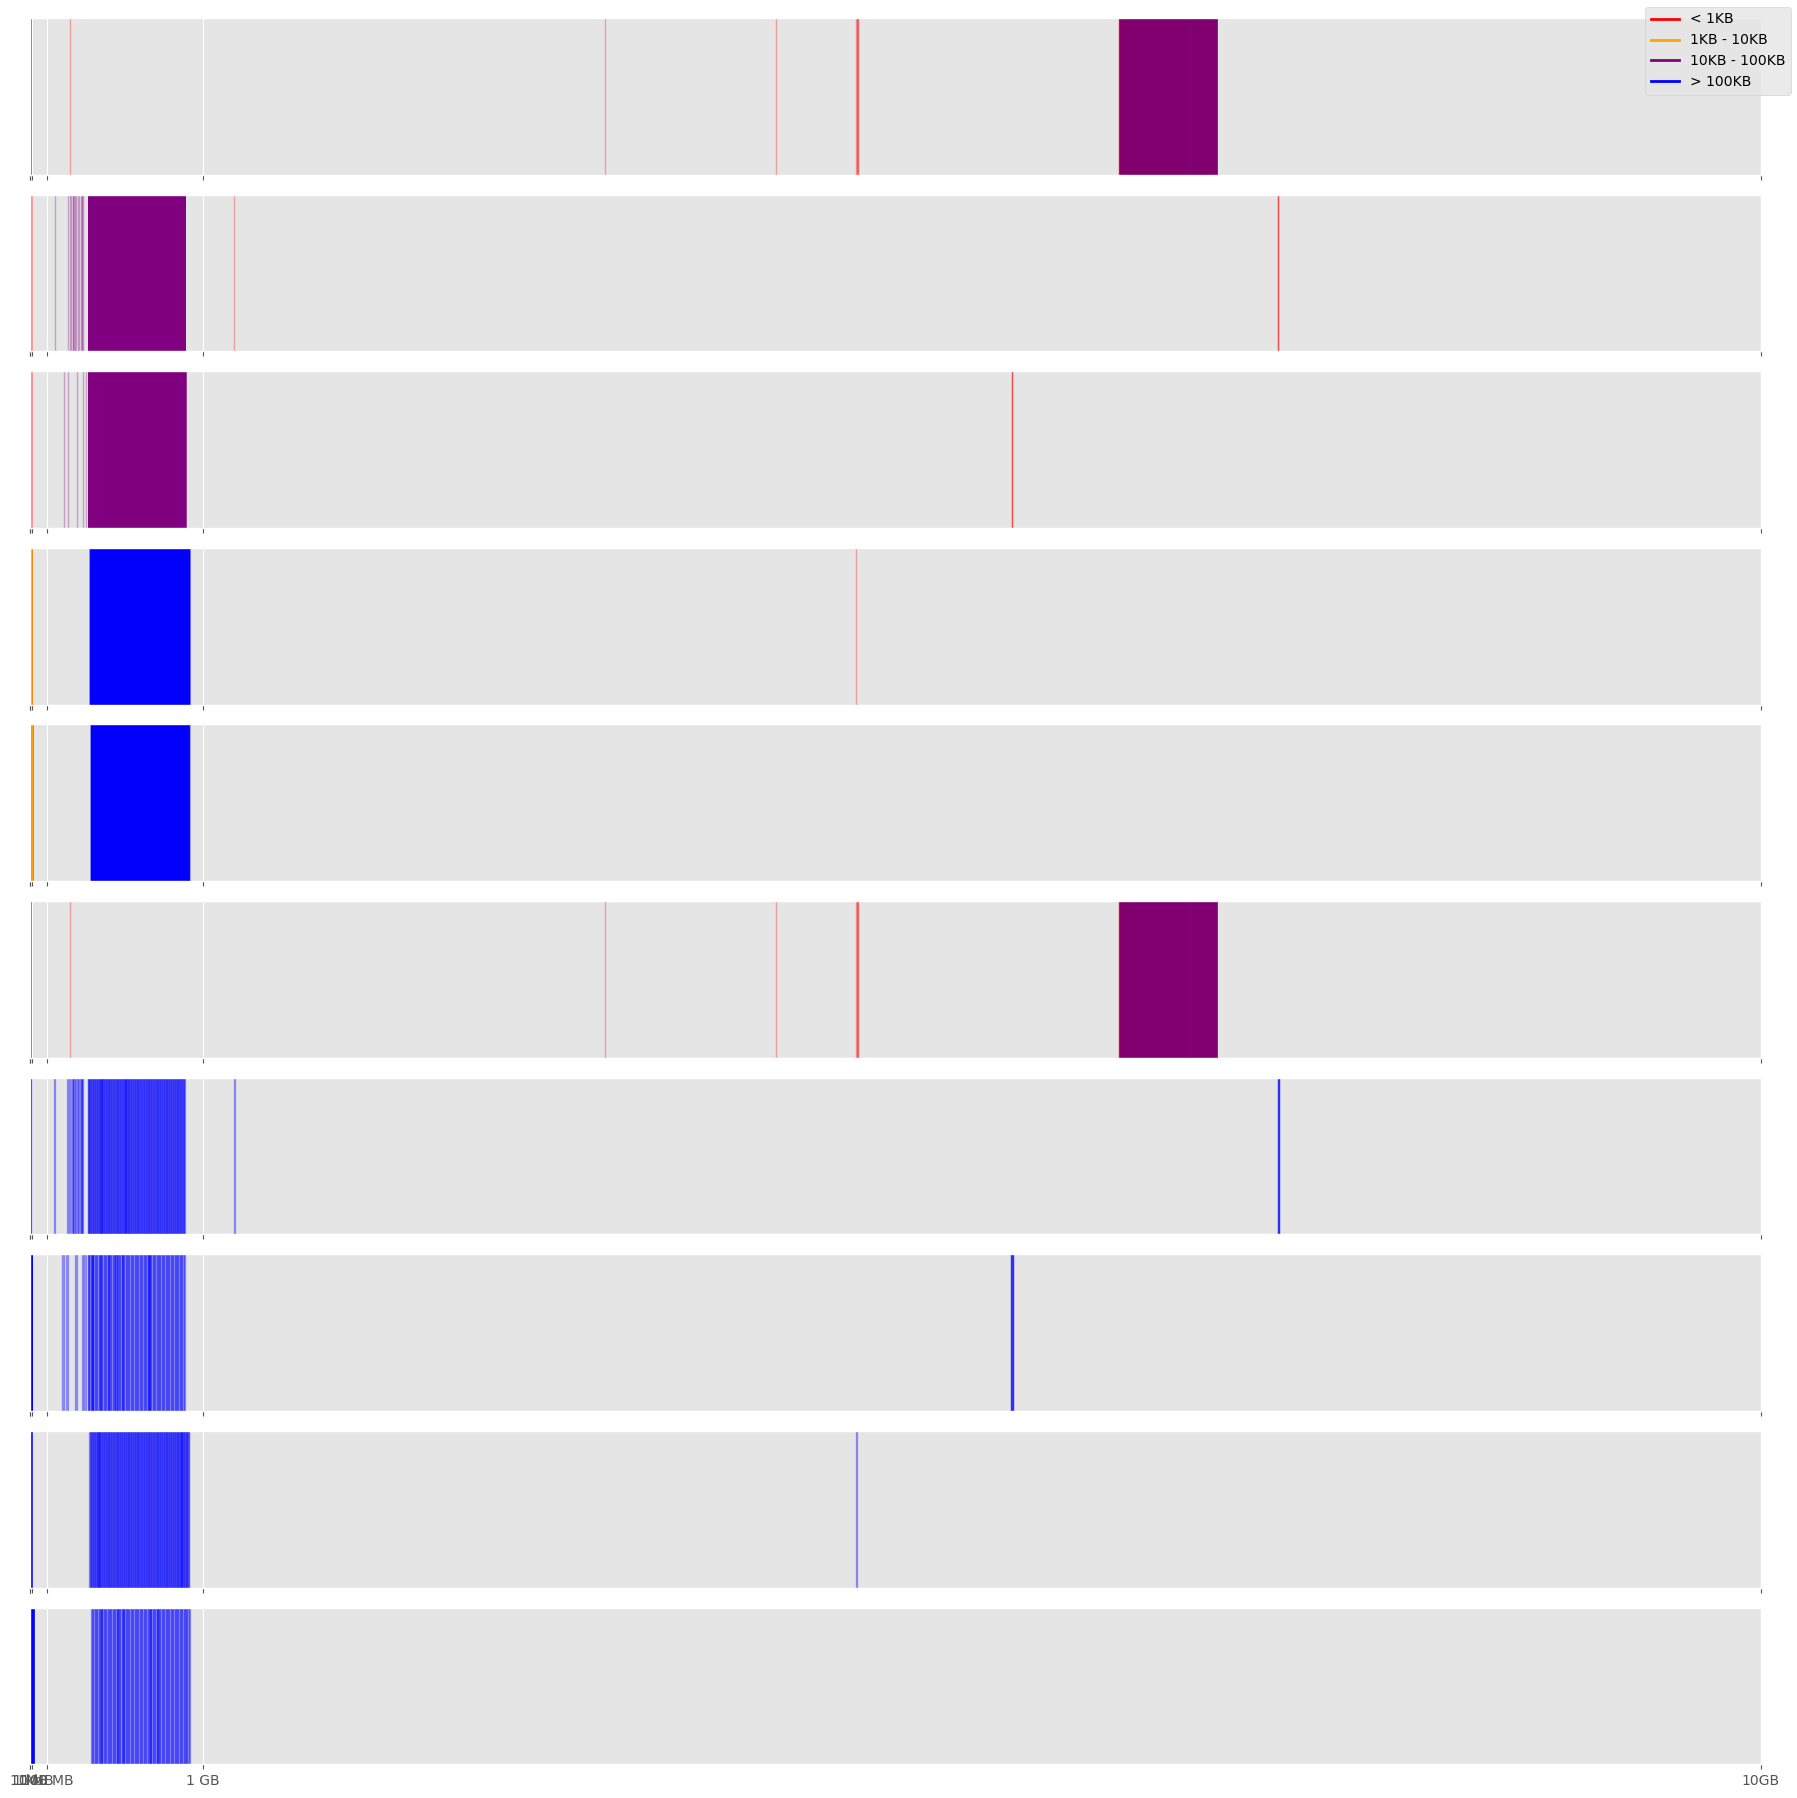

In [24]:
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import numpy as np

fig, axs = plt.subplots(ncols=1, nrows=len(ranges), figsize=(18, 18), sharex=True)

for index, range_stats in enumerate(ranges):
    rdf = range_stats["ranges"]
    file_size = range_stats["file_size"]

    bins = [0, 1 * 1024, 10 * 1024, 100 * 1024, np.inf]
    colors = ['red', 'orange', 'purple', 'blue']
    labels = ['< 1KB', '1KB - 10KB', '10KB - 100KB', '> 100KB']
    rdf['color'] = pd.cut(rdf['size'], bins=bins, labels=colors)
    rdf['label'] = pd.cut(rdf['size'], bins=bins, labels=labels)

    for i, row in rdf.iterrows():
        rect = patches.Rectangle((row['start'], 0), row['end']-row['start'], 1, 
                                 linewidth=1, edgecolor=row['color'], facecolor=row['color'], alpha=0.3)
        axs[index].add_patch(rect)

    axs[index].set_xlim(0, 1.1e9)
    axs[index].set_ylim(0, 1)
    axs[index].set_yticklabels("")
    axs[index].set_yticks([])
    xticks = [
        1024*1024,
        10*1024*1024,
        100*1024*1024,
        1024*1024*1024,
        10*1024*1024*1024,
    ]
    xtick_labels = [
        '1 MB',
        '10 MB',
        '100 MB',
        '1 GB',
        '10GB'
    ]
    axs[index].set_xticks(xticks)
    axs[index].set_xticklabels(xtick_labels)

# The last axis will retain the x-ticks
axs[-1].tick_params(axis='x', which='both', bottom=True, labelbottom=True)

# Create custom legend handles
legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) for color, label in zip(colors, labels)]
# plt.legend(handles=legend_elements, title="Request Size",  loc='upper right')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=legend_elements, loc='upper right')

# plt.suptitle(f'ATL06 Read Pattern. File Size: {round(file_size/1e6,2)} MB, Total Requests:{len(rdf)}, Requests <10kb: {len(rdf[rdf["size"]<10000])}', fontsize=18)
plt.tight_layout()

plt.show()

In [ ]:
# import holoviews as hv
# from holoviews.operation.datashader import rasterize
# import datashader as ds
# hv.extension("bokeh")

# xticks = [
#     (1024*1024, '1MB'),
#     (10*1024*1024, '10MB'),
#     (100*1024*1024, '100MB'),
#     (1024*1024*1024, '1GB'),
#     (1024*1024*1024*10, '10GB')
# ]

# # Function to create Rectangles
# def get_rectangles(ranges):
#     rectangles = hv.Rectangles([])  # Start with an empty set of rectangles
#     for i, row in ranges[0]["ranges"].iterrows():
#         rect = (row['start'], 0, row['end'], 1)  # Define rectangle bounds
#         rectangles = rectangles * hv.Rectangles([rect]).opts(
#             color=row['color'], 
#             line_color=row['color'], 
#             line_width=1
#         )
#     return rectangles

# # Create an overlay of all rectangles
# rectangles = get_rectangles(ranges)

# # Rasterize the plot using Datashader
# rasterized_rectangles = rasterize(rectangles, width=1200, height=300)

# # Customize the plot with xticks and limits
# rasterized_rectangles.opts(
#     xlabel='File Offset', ylabel='', xticks=xticks, 
#     xlim=(0, file_size), ylim=(0, 1), 
#     show_legend=True, legend_position='top_right'
# )
